# Overview


- **3.0. Data Preparation**
  - 3.0.1. *Vocabulary*
  - 3.0.2. *Dataset*
<br><br>  

- **3.1. Word2Vec from Scratch**
  - 3.1.1. *CBOW*
  - 3.1.2. *Skipgram*
  - 3.1.3. *Word2Vec Dataset*
  - 3.1.4. *Train a CBOW model*
  - 3.1.5. *Train a Skipgram model*
  - 3.1.6. *Loading Pre-trained Embeddings*
  
<br><br>



In [7]:
!pip3 install sklearn torch tqdm nltk lazyme requests gensim
!python -m nltk.downloader movie_reviews

  Using cached https://files.pythonhosted.org/packages/a0/8e/719275cb952330a14752655141ceda5f6ec4c065eb3f54993943f89faa4e/gensim-3.7.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8f/35/6da51b44a808b5caf05957e9b38f4c4827302120cd1cde2ca3fd712af412/boto3-1.9.83-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2c/f4/745026b1f20d687b14b5ad26b3087121596a81ae055ecb28b6187273978b/botocore-1.12.83-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b7/31/05c8d001f7f87f0f07289a5fc0fc3832e9a57f2dbd4d3b0fee70e0d51365/jmespath-0.9.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d7/14/2a0004d487464d120c9fb85313a75cd3d71a7506955be458eebfe19a6b1d/s3transfer-0.1.13-py2.py3-none-any.whl
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/home/kenny/anaconda3/envs/pytorch/lib/python3.6/runpy.

# 3.0. Data Preparation

Before we train our own embeddings, lets first understand how to read text data into pytorch.
The native pytorch way to load datasets is to use the `torch.utils.data.Dataset` object.

There are already several other libraries that help with loading text datasets, e.g. 

 - FastAI https://docs.fast.ai/text.data.html
 - AllenNLP https://allenai.github.io/allennlp-docs/api/allennlp.data.dataset.html
 - Torch Text https://github.com/pytorch/text#data
 - Texar https://texar.readthedocs.io/en/latest/code/data.html#id4 
 - SpaCy https://github.com/explosion/thinc
 

But to truly understand and use it for the custom datasets you'll see at work, lets learn it the native way.

## 3.0.1  Vocabulary

Given a text, the first thing to do is to build a vocabulary (i.e. a dictionary of unique words) and assign an index to each unique word.

In [18]:
import random
from itertools import chain

from tqdm import tqdm
from nltk import sent_tokenize, word_tokenize
from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np



In [10]:

text = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()

tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(text)]

uniq_tokens = set(chain(*tokenized_text))

vocab = {}   # Assign indices to every word.
idx2tok = {} # Also keep an dict of index to words.
for i, token in enumerate(uniq_tokens):
    vocab[token] = i
    idx2tok[i] = token

In [17]:
vocab

[['language',
  'users',
  'never',
  'choose',
  'words',
  'randomly',
  ',',
  'and',
  'language',
  'is',
  'essentially',
  'non-random',
  '.'],
 ['statistical',
  'hypothesis',
  'testing',
  'uses',
  'a',
  'null',
  'hypothesis',
  ',',
  'which',
  'posits',
  'randomness',
  '.'],
 ['hence',
  ',',
  'when',
  'we',
  'look',
  'at',
  'linguistic',
  'phenomena',
  'in',
  'corpora',
  ',',
  'the',
  'null',
  'hypothesis',
  'will',
  'never',
  'be',
  'true',
  '.'],
 ['moreover',
  ',',
  'where',
  'there',
  'is',
  'enough',
  'data',
  ',',
  'we',
  'shall',
  '(',
  'almost',
  ')',
  'always',
  'be',
  'able',
  'to',
  'establish',
  'that',
  'it',
  'is',
  'not',
  'true',
  '.'],
 ['in',
  'corpus',
  'studies',
  ',',
  'we',
  'frequently',
  'do',
  'have',
  'enough',
  'data',
  ',',
  'so',
  'the',
  'fact',
  'that',
  'a',
  'relation',
  'between',
  'two',
  'phenomena',
  'is',
  'demonstrably',
  'non-random',
  ',',
  'does',
  'not',
  'su

In [175]:
# Retrieve the index of the word 'corpora'
vocab['corpora']

38

In [11]:
# The indexed representation of the first sentence.

sent0 = tokenized_text[0]

[vocab[token] for token in sent0] 

[57, 60, 33, 17, 65, 79, 63, 21, 57, 1, 84, 13, 9]

### Pet Peeve

I (Liling) don't really like to write my own vectorizer the `gensim` has functions that are optimized for such operations. In fact, I've written a [whole preprocessing pipeline library for me to use for language modelling and machine translation purposes](https://github.com/alvations/komorebi/blob/master/komorebi/text.py) =)

Using `gensim`, I would have written the above as such:

In [19]:
from gensim.corpora.dictionary import Dictionary
vocab = Dictionary(tokenized_text)

In [20]:
# Note the key-value order is different of gensim from the native Python's
dict(vocab.items())

{0: ',',
 1: '.',
 2: 'and',
 3: 'choose',
 4: 'essentially',
 5: 'is',
 6: 'language',
 7: 'never',
 8: 'non-random',
 9: 'randomly',
 10: 'users',
 11: 'words',
 12: 'a',
 13: 'hypothesis',
 14: 'null',
 15: 'posits',
 16: 'randomness',
 17: 'statistical',
 18: 'testing',
 19: 'uses',
 20: 'which',
 21: 'at',
 22: 'be',
 23: 'corpora',
 24: 'hence',
 25: 'in',
 26: 'linguistic',
 27: 'look',
 28: 'phenomena',
 29: 'the',
 30: 'true',
 31: 'we',
 32: 'when',
 33: 'will',
 34: '(',
 35: ')',
 36: 'able',
 37: 'almost',
 38: 'always',
 39: 'data',
 40: 'enough',
 41: 'establish',
 42: 'it',
 43: 'moreover',
 44: 'not',
 45: 'shall',
 46: 'that',
 47: 'there',
 48: 'to',
 49: 'where',
 50: 'arbitrary',
 51: 'between',
 52: 'corpus',
 53: 'demonstrably',
 54: 'do',
 55: 'does',
 56: 'fact',
 57: 'frequently',
 58: 'have',
 59: 'inference',
 60: 'relation',
 61: 'so',
 62: 'studies',
 63: 'support',
 64: 'two',
 65: 'are',
 66: 'associations',
 67: 'evidence',
 68: 'experimental',
 69: 'fr

In [14]:
vocab.token2id['corpora']

23

In [15]:
vocab.doc2idx(sent0)

[6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]

The "indexed form" of the tokens in the sentence forms the ***vectorized*** input to the `nn.Embedding` layer in PyTorch.

# 3.0.2 Dataset

Lets try creating a `torch.utils.data.Dataset` object.

In [24]:
from torch.utils.data import Dataset, DataLoader

class Text(Dataset):
    def __init__(self, tokenized_texts):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.vocab = Dictionary(tokenized_text)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return self.vectorize(self.sents[index])

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return {'x': self.vocab.doc2idx(tokens)}
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [25]:
text_dataset = Text(tokenized_text)

In [26]:
text_dataset[0] # First sentence.

{'x': [6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]}

### Return `dict` in `__getitem__()`

This is nice if we're just representing sentences/documents by their indices but when we're doing machine learning, we usually have `X` and `Y`. 

If we have labels for the each sentence, we can also put it into to `__getitem__()` by having it return a dictionary.

In [27]:
from torch.utils.data import Dataset, DataLoader

class LabeledText(Dataset):
    def __init__(self, tokenized_texts, labels):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.labels = labels # Sentence level labels.
        self.vocab = Dictionary(self.sents)

Python
    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return {'X': self.vectorize(self.sents[index]), 'Y': self.labels[index]}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

### Lets try the `LabeledDataset` on a movie review corpus

In [28]:
from nltk.corpus import movie_reviews

In [29]:
documents = []
labels = []

for fileid in tqdm(movie_reviews.fileids()):
    label = fileid.split('/')[0]
    doc = word_tokenize(movie_reviews.open(fileid).read())
    documents.append(doc)
    labels.append(label)

100%|██████████| 2000/2000 [00:17<00:00, 114.56it/s]


In [30]:
documents[0]

['plot',
 ':',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 ',',
 'drink',
 'and',
 'then',
 'drive',
 '.',
 'they',
 'get',
 'into',
 'an',
 'accident',
 '.',
 'one',
 'of',
 'the',
 'guys',
 'dies',
 ',',
 'but',
 'his',
 'girlfriend',
 'continues',
 'to',
 'see',
 'him',
 'in',
 'her',
 'life',
 ',',
 'and',
 'has',
 'nightmares',
 '.',
 'what',
 "'s",
 'the',
 'deal',
 '?',
 'watch',
 'the',
 'movie',
 'and',
 '``',
 'sorta',
 '``',
 'find',
 'out',
 '.',
 '.',
 '.',
 'critique',
 ':',
 'a',
 'mind-fuck',
 'movie',
 'for',
 'the',
 'teen',
 'generation',
 'that',
 'touches',
 'on',
 'a',
 'very',
 'cool',
 'idea',
 ',',
 'but',
 'presents',
 'it',
 'in',
 'a',
 'very',
 'bad',
 'package',
 '.',
 'which',
 'is',
 'what',
 'makes',
 'this',
 'review',
 'an',
 'even',
 'harder',
 'one',
 'to',
 'write',
 ',',
 'since',
 'i',
 'generally',
 'applaud',
 'films',
 'which',
 'attempt',
 'to',
 'break',
 'the',
 'mold',
 ',',
 'mess',
 'with',
 'your',
 'head',
 '

In [31]:
labeled_dataset = LabeledText(documents, labels)

In [34]:
labeled_dataset[0]['X']  # First review in the data.

[243,
 17,
 314,
 294,
 77,
 140,
 307,
 20,
 68,
 237,
 6,
 97,
 34,
 299,
 98,
 8,
 302,
 135,
 167,
 33,
 22,
 8,
 226,
 220,
 297,
 145,
 87,
 6,
 60,
 158,
 136,
 74,
 307,
 262,
 157,
 165,
 153,
 179,
 6,
 34,
 149,
 214,
 8,
 333,
 2,
 297,
 82,
 18,
 326,
 297,
 204,
 34,
 19,
 280,
 19,
 124,
 230,
 8,
 8,
 8,
 79,
 17,
 20,
 199,
 204,
 129,
 297,
 294,
 133,
 296,
 311,
 225,
 20,
 322,
 75,
 164,
 6,
 60,
 245,
 169,
 165,
 20,
 322,
 46,
 234,
 8,
 337,
 168,
 333,
 188,
 304,
 253,
 33,
 108,
 148,
 226,
 307,
 345,
 6,
 272,
 163,
 132,
 37,
 122,
 337,
 42,
 307,
 59,
 297,
 201,
 6,
 196,
 341,
 348,
 152,
 34,
 290,
 4,
 185,
 156,
 1,
 195,
 5,
 6,
 60,
 300,
 38,
 142,
 34,
 46,
 328,
 220,
 189,
 28,
 315,
 220,
 122,
 6,
 34,
 301,
 128,
 173,
 86,
 208,
 276,
 304,
 226,
 76,
 8,
 302,
 263,
 307,
 150,
 293,
 304,
 246,
 209,
 72,
 6,
 60,
 113,
 169,
 295,
 8,
 277,
 333,
 38,
 297,
 248,
 341,
 297,
 204,
 18,
 331,
 6,
 170,
 186,
 247,
 168,
 296,
 169,
 2,

In [35]:
labeled_dataset[0]['Y']  # Label of the first review in the data. 

'neg'

# 3.1 Word2Vec Training

Word2Vec has two training variants:

 - **Continuous Bag of Words (CBOW)**: Predict center word from (bag of) context words.
 - **Skip-grams**: Predict context words given center word.
  
Visually, they look like this:

<img src="https://ibin.co/4UIznsOEyH7t.png" width="500">

## 3.1.1. CBOW

CBOW windows through the sentence and picks out the center word as the `Y` and the surrounding context words as the inputs `X`. 



In [43]:
def per_window(sequence, n=1):
    """
    From http://stackoverflow.com/q/42220614/610569
        >>> list(per_window([1,2,3,4], n=2))
        [(1, 2), (2, 3), (3, 4)]
        >>> list(per_window([1,2,3,4], n=3))
        [(1, 2, 3), (2, 3, 4)]
    """
    start, stop = 0, n
    seq = list(sequence)
    while stop <= len(seq):
        yield seq[start:stop]
        start += 1
        stop += 1

def cbow_iterator(tokens, window_size):
    n = window_size * 2 + 1
    for window in per_window(tokens, n):
        target = window.pop(window_size)
        yield window, target   # X = window ; Y = target. 


In [44]:
sent0 = ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 
         'and', 'language', 'is', 'essentially', 'non-random', '.']

In [45]:
list(cbow_iterator(sent0, 2)) 

[(['language', 'users', 'choose', 'words'], 'never'),
 (['users', 'never', 'words', 'randomly'], 'choose'),
 (['never', 'choose', 'randomly', ','], 'words'),
 (['choose', 'words', ',', 'and'], 'randomly'),
 (['words', 'randomly', 'and', 'language'], ','),
 (['randomly', ',', 'language', 'is'], 'and'),
 ([',', 'and', 'is', 'essentially'], 'language'),
 (['and', 'language', 'essentially', 'non-random'], 'is'),
 (['language', 'is', 'non-random', '.'], 'essentially')]

In [46]:
list(cbow_iterator(sent0, 3)) 

[(['language', 'users', 'never', 'words', 'randomly', ','], 'choose'),
 (['users', 'never', 'choose', 'randomly', ',', 'and'], 'words'),
 (['never', 'choose', 'words', ',', 'and', 'language'], 'randomly'),
 (['choose', 'words', 'randomly', 'and', 'language', 'is'], ','),
 (['words', 'randomly', ',', 'language', 'is', 'essentially'], 'and'),
 (['randomly', ',', 'and', 'is', 'essentially', 'non-random'], 'language'),
 ([',', 'and', 'language', 'essentially', 'non-random', '.'], 'is')]

## 3.1.2. Skipgram

Skipgram training windows through the sentence and pictures out the center word as the input `X` and the context words as the outputs `Y`, additionally, it will randommly sample words not in the window as **negative samples**.

In [47]:
def skipgram_iterator(tokens, window_size):
    n = window_size * 2 + 1 
    for i, window in enumerate(per_window(tokens, n)):
        target = window.pop(window_size)
        # Generate positive samples.
        for context_word in window:
            yield target, context_word, 1
        # Generate negative samples.
        for _ in range(n-1):
            leftovers = tokens[:i] + tokens[i+n:]
            yield target, random.choice(leftovers), 0

In [48]:
print(' '.join(sent0))
list(skipgram_iterator(sent0, 2))

language users never choose words randomly , and language is essentially non-random .


[('never', 'language', 1),
 ('never', 'users', 1),
 ('never', 'choose', 1),
 ('never', 'words', 1),
 ('never', '.', 0),
 ('never', 'randomly', 0),
 ('never', 'language', 0),
 ('never', 'and', 0),
 ('choose', 'users', 1),
 ('choose', 'never', 1),
 ('choose', 'words', 1),
 ('choose', 'randomly', 1),
 ('choose', '.', 0),
 ('choose', 'non-random', 0),
 ('choose', 'and', 0),
 ('choose', 'non-random', 0),
 ('words', 'never', 1),
 ('words', 'choose', 1),
 ('words', 'randomly', 1),
 ('words', ',', 1),
 ('words', 'is', 0),
 ('words', 'non-random', 0),
 ('words', 'users', 0),
 ('words', 'users', 0),
 ('randomly', 'choose', 1),
 ('randomly', 'words', 1),
 ('randomly', ',', 1),
 ('randomly', 'and', 1),
 ('randomly', 'never', 0),
 ('randomly', '.', 0),
 ('randomly', 'never', 0),
 ('randomly', 'language', 0),
 (',', 'words', 1),
 (',', 'randomly', 1),
 (',', 'and', 1),
 (',', 'language', 1),
 (',', 'essentially', 0),
 (',', 'language', 0),
 (',', 'never', 0),
 (',', 'users', 0),
 ('and', 'randomly',

## 3.1.3 Word2Vec Dataset

Now that we know what are the inputs `X` and outputs `Y` of the Word2Vec task. 

Lets put everything together and modify the `Dataset` so that `__getitem__` retrieves CBOW or Skipgram formats.

In [49]:
from functools import partial
from torch.utils.data import Dataset, DataLoader
from torch import functional as F

class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        self.vocab = Dictionary(self.sents)
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        """
            >>> tokens = ['language', 'users', 'never', 'choose', 'words', 'randomly', 
            ...           ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']
            >>> cbow_iterator(tokens, 2)
            [(['language', 'users', 'choose', 'words'], 'never'),
            (['users', 'never', 'words', 'randomly'], 'choose'),
            (['never', 'choose', 'randomly', ','], 'words'),
            (['choose', 'words', ',', 'and'], 'randomly'),
            (['words', 'randomly', 'and', 'language'], ','),
            (['randomly', ',', 'language', 'is'], 'and'),
            ([',', 'and', 'is', 'essentially'], 'language'),
            (['and', 'language', 'essentially', 'non-random'], 'is'),
            (['language', 'is', 'non-random', '.'], 'essentially')]
        """
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        """
            >>> tokens = ['language', 'users', 'never', 'choose', 'words', 'randomly', 
            ...           ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']
            >>> list(skipgram_iterator(tokens, 2))[:10]
            [('never', 'language', 1),
             ('never', 'users', 1),
             ('never', 'choose', 1),
             ('never', 'words', 1),
             ('never', 'non-random', 0),
             ('never', 'is', 0),
             ('never', 'and', 0),
             ('never', 'and', 0),
             ('choose', 'users', 1),
             ('choose', 'never', 1)]
        """
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

## 3.1.5. Train a CBOW model

### Lets Get Some Data

Lets take Kilgarriff (2005) , "Language is never ever, ever random". 

In [50]:
import os
import requests

# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with open('language-never-random.txt') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with open('language-never-random.txt', 'w') as fout:
        fout.write(text)

tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')

In [110]:
# Sanity check, lets take a look at the data.
print(tokenized_text[0])
w2v_dataset.unvectorize([35, 188, 6, 232, 0])


['language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


','

In [71]:
from lazyme import color_str

def visualize_predictions(x, y, prediction, vocab, window_size, unk='<unk>'):
    left = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[:window_size]])
    right = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[window_size:]])
    target = vocab.get(int(y), '<unk>')

    if not prediction:
        predicted_word = '______'
    else:
        predicted_word = vocab.get(int(prediction), '<unk>') 
    print(color_str(target, 'green'), '\t' if len(target) > 6 else '\t\t', 
          left, color_str(predicted_word, 'green' if target == predicted_word else 'red'), right)
    

sent_idx = 10
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
print(' '.join(w2v_dataset.sents[sent_idx]))
for w2v_io in w2v_dataset[sent_idx]:
    context = x = tensor(w2v_io['x'])
    target = y = tensor(w2v_io['y'])
    visualize_predictions(context, target, None, w2v_dataset.vocab, window_size)

the bulk of linguistic questions concern the dis- tinction between a and m. a linguistic account of a phenomenon gen- erally gives us reason to view the relation between , for example , a verb ’ s syntax and its semantics , as motivated rather than arbitrary .
of 		 the bulk ______ linguistic questions
linguistic 	 bulk of ______ questions concern
questions 	 of linguistic ______ concern the
concern 	 linguistic questions ______ the dis-
the 		 questions concern ______ dis- tinction
dis- 		 concern the ______ tinction between
tinction 	 the dis- ______ between a
between 	 dis- tinction ______ a and
a 		 tinction between ______ and m.
and 		 between a ______ m. a
m. 		 a and ______ a linguistic
a 		 and m. ______ linguistic account
linguistic 	 m. a ______ account of
account 	 a linguistic ______ of a
of 		 linguistic account ______ a phenomenon
a 		 account of ______ phenomenon gen-
phenomenon 	 of a ______ gen- erally
gen- 		 a phenomenon ______ erally gives
erally 		 phenomenon gen- 

## Fill-in the code for the CBOW Model

In [52]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        # Flatten the embeddings from multiple context words
        # into a single vector.
        embedded = self.embeddings(inputs).view((1, -1))
        # Apply the first linear layer and activation.
        hid = F.relu(self.linear1(embedded))
        # Apply a second linear and predict
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        # Return the weights
        return log_probs


In [53]:
from sklearn.model_selection import train_test_split

tokenized_text_train, tokenized_text_test = train_test_split(tokenized_text, test_size=0.1, random_state=42)
len(tokenized_text_train), len(tokenized_text_test)

(211, 24)

In [114]:
embd_size = 100
learning_rate = 0.003
hidden_size = 100
window_size = 2

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
vocab_size = len(w2v_dataset.vocab)+1

criterion = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, window_size, hidden_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x'])
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long))
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))



100%|██████████| 100/100 [11:47<00:00,  6.24s/it]


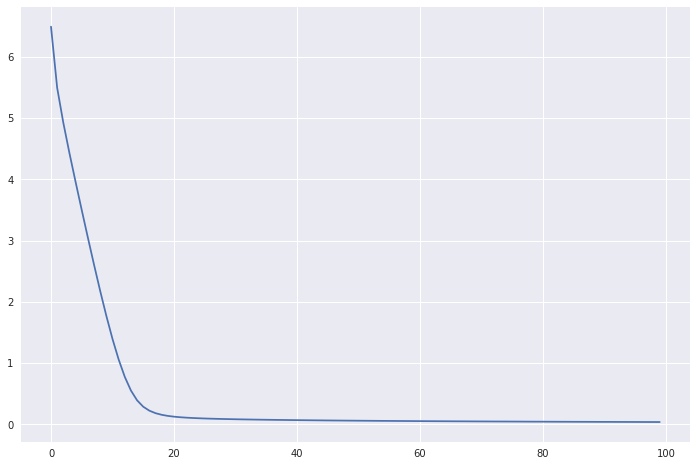

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

# Apply and Evaluate the CBOW Model 

In [116]:
from lazyme import color_str

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            print(w2v_io['x'],w2v_io['y'])
            _, prediction =  torch.max(model(x), 1)
            print(int(prediction))
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

[34, 173, 696, 35] 28
0
is 		 the problem ______ essentially this
[173, 28, 35, 217] 696
59
essentially 	 problem is to this :
[28, 696, 217, 161] 35
59
this 		 is essentially to : if
[696, 35, 161, 95] 217
39
: 		 essentially this as if a
[35, 217, 95, 480] 161
39
if 		 this : as a word
[217, 161, 480, 78] 95
95
a 		 : if a word (
[161, 95, 78, 71] 480
114
word 		 if a i ( or
[95, 480, 71, 659] 78
78
( 		 a word ( or bigram
[480, 78, 659, 0] 71
91
or 		 word ( 1993 bigram ,
[78, 71, 0, 71] 659
79
bigram 		 ( or ) , or
[0, 71, 0, 71] -1
863
<unk> 		 , or plan , or
[0, 71, 383, 18] -1
944
<unk> 		 , or sunday etc .
[34, 89, 95, 683] 28
78
is 		 the web ( a vast
[89, 28, 683, 897] 95
70
a 		 web is not vast re-
[28, 95, 897, 1244] 683
416
vast 		 is a theoretical re- source
[95, 683, 1244, 111] 897
4
re- 		 a vast and source for
[683, 897, 111, 178] 1244
0
source 		 vast re- ______ for many
[28, 135, 748, 28] 34
0
the 		 is that ______ association is
[135, 34, 28, 134] 748
565
associatio

always 		 do not be have enough
[70, 325, 155, 170] 263
35
have 		 not always this enough data
[325, 263, 170, 59] 155
155
enough 		 always have enough data to
[263, 155, 59, 609] 170
170
data 		 have enough data to reject
[155, 170, 609, 34] 59
59
to 		 enough data to reject the
[170, 59, 34, 192] 609
609
reject 		 data to reject the null
[59, 609, 192, 26] 34
34
the 		 to reject the null hypothesis
[609, 34, 26, 0] 192
192
null 		 reject the null hypothesis ,
[34, 192, 0, 169] 26
26
hypothesis 	 the null hypothesis , but
[192, 26, 169, 135] 0
59
, 		 null hypothesis to but that
[26, 0, 135, 28] 169
169
but 		 hypothesis , but that is
[0, 169, 28, 95] 135
117
that 		 , but language is a
[28, 95, 264, 217] -1
46
<unk> 		 is a between issue :
[264, 217, 57, 28] 1116
0
wherever 	 issue : ______ there is
[217, 1116, 28, 155] 57
57
there 		 : wherever there is enough
[1116, 57, 155, 170] 28
28
is 		 wherever there is enough data
[57, 28, 170, 0] 155
155
enough 		 there is enough data ,
[28

In [117]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.25957446808510637


# Go back to the 90th Epoch

In [118]:
model_90 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_90 = torch.nn.DataParallel(model_90)
model_90.load_state_dict(torch.load('cbow_checkpoint_80.pt'))
model_90.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1304, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1304, bias=True)
  )
)

In [119]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_90(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem ______ essentially this
essentially 	 problem is to this :
this 		 is essentially to : if
: 		 essentially this as if a
if 		 this : as a word
a 		 : if and word (
word 		 if a i ( or
( 		 a word ( or bigram
or 		 word ( 1993 bigram ,
bigram 		 ( or ) , or
<unk> 		 , or plan , or
<unk> 		 , or sunday etc .
is 		 the web ( a vast
a 		 web is not vast re-
vast 		 is a theoretical re- source
re- 		 a vast and source for
source 		 vast re- ______ for many
the 		 is that ______ association is
association 	 that the probability is random
is 		 the association of random ,
random 		 association is inappropriate , arbitrary
, 		 is random ______ arbitrary ,
arbitrary 	 random , or , motivated
, 		 , arbitrary or motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- ) ( r
, 		 ( r ) a ,
<unk> 		 a , firstly , p
their 		 however , and methods are
example 	 , for example , from
, 		 for example verbs from just
from 		 example , for just those
<unk> 		 just those

corpora 	 that our help are not
are 		 our corpora does not randomly
not 		 corpora are some randomly generated
randomly 	 are not our generated ,
generated 	 not randomly random , and
, 		 randomly generated ______ and the
and 		 generated , are the hypothesis
the 		 , and diana hypothesis test
hypothesis 	 and the hypothesis test con-
<unk> 		 test con- of the fact
<unk> 		 cases are frequently in section
<unk> 		 of linguistic probability concern the
<unk> 		 the dis- relationship between a
<unk> 		 a and random a linguistic
<unk> 		 a linguistic number of a
<unk> 		 reason to establish the relation
between 	 the relation statistic , for
, 		 relation between corpus for example
for 		 between , for example ,
example 	 , for example , a
, 		 for example at a verb
a 		 example , or verb ’
verb 		 , a is ’ s
’ 		 a verb ’ s syntax
s 		 verb ’ s syntax and
syntax 		 ’ s definition and its
<unk> 		 and its randomness , as
motivated 	 , as ______ rather than
rather 		 as motivated are tha

In [120]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.251063829787234


# How to Handle Unknown Words? 

This is not the best way to handle unknown words, but we can simply assign an index for unknown words.

In [122]:
vocab = Dictionary(['this is a foo bar sentence'.split()])
dict(vocab.items())

{0: 'a', 1: 'bar', 2: 'foo', 3: 'is', 4: 'sentence', 5: 'this'}

In [123]:
# See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens
vocab = Dictionary(['this is a foo bar sentence'.split()])
special_tokens = {'<pad>': 0, '<unk>': 1}
vocab.patch_with_special_tokens(special_tokens)
dict(vocab.items())

{0: '<pad>',
 1: '<unk>',
 2: 'foo',
 3: 'is',
 4: 'sentence',
 5: 'this',
 6: 'a',
 7: 'bar'}

# Lets Rewrite the `Word2VecText` Object

Now with the (i) unknown word patch in the vocabulary as well as (ii) `skipgram_iterator`

In [125]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Add the unknown word patch here.
        self.vocab = Dictionary(self.sents)
        special_tokens = {'<pad>': 0, '<unk>': 1}
        self.vocab.patch_with_special_tokens(special_tokens)
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                yield {'x': (focus, random.choice(leftovers)), 'y':0}

In [126]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

In [139]:
embd_size = 100
learning_rate = 0.03
hidden_size = 300
window_size = 3

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.MSELoss() # binary classification.
model = SkipGram(vocab_size, embd_size,)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epcoh_loss = 0
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x1, x2 = w2v_io['x']
            x1, x2 = tensor(x1), tensor(x2)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.float))
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x1, x2)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epcoh_loss += float(loss)
    torch.save(model.state_dict(), 'skipgram_checkpoint_{}.pt'.format(_e))
    losses.append(epcoh_loss)




  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 1/211 [00:00<01:28,  2.38it/s]

  1%|          | 2/211 [00:00<01:29,  2.34it/s]

  2%|▏         | 5/211 [00:01<00:55,  3.68it/s]

  3%|▎         | 6/211 [00:02<01:11,  2.86it/s]

  3%|▎         | 7/211 [00:02<01:24,  2.41it/s]

  4%|▍         | 8/211 [00:07<03:00,  1.12it/s]

  4%|▍         | 9/211 [00:07<02:54,  1.16it/s]

  5%|▍         | 10/211 [00:08<02:41,  1.25it/s]
Exception in thread Thread-43:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set chan

KeyboardInterrupt: 

In [141]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        _, prediction =  torch.max(model(x1, x2), 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [142]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.5


## Download the Collobert and Weston SENNA Embeddings

In [153]:
!pip install kaggle
!mkdir -p .kaggle
!echo '{"username":"natgillin","key":"54ae95ab760b52c3307ed4645c6c9b5d"}' > .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d alvations/vegetables-senna-embeddings --force -p ./


    100% |████████████████████████████████| 61kB 4.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 5.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /Users/liling.tan/Library/Caches/pip/wheels/5a/2d/0c/9fc539e558586b9ed9127916a7f4e620163c24cc97460b1188
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /Users/liling.tan/Library/Caches/pip/wheels/2b/9e/c8/14a18ab55d8f144384de8186a3df8401dcc9264936f71d470f
Successfully built kaggle python-slugify
sframe 2.1 requires boto==2.33.0, which is not installed.
sframe 2.1 requires multipledispatch>=0.4.7, which is not installed.
sframe 2.1 has requirement certifi==2015.04.28, but you'll have certifi 2018.8.24 which is incompatible.
sframe 2.1 has requirement decorator==4.0.9, but you'll have decorator 4.3.0 which is incompatible.
sframe 2.1 has requirement requests==2.9.1, but you'll have requests 2.19.1 which is incompatible.
sframe 2.1 has requirement 

## Lets Rewrite the Word2VecText object with the pretrained embeddings. 


In [21]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=-1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

## Test Pretrained Embeddings on the Skipgram Task

In [22]:
class SkipGram(nn.Module):
    def __init__(self, pretrained_npy):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding.???(pretrained_npy)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = ???
        log_probs = F.logsigmoid(score)
        return log_probs

In [30]:
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
pretrained_npy = torch.tensor(np.load('senna.wiki-reuters.lm2.50d.npy'))
pretrained_model = SkipGram(pretrained_npy)

In [31]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        pretrained_model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        if -1 in (x1, x2): # Skip unknown words.
            continue
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        with torch.no_grad():
            logprobs = pretrained_model(x1, x2)
            _, prediction =  torch.max(logprobs, 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [32]:
with open('senna.wiki-reuters.lm2.50d.txt') as fin:
    pretrained_keys = {line.strip():i for i, line in enumerate(fin)}

In [33]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.5009680542110359


## Test Pretrained Embeddings on the CBOW Task

In [63]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        # See https://pytorch.org/docs/stable/nn.html?highlight=from_pretrained#torch.nn.Embedding.from_pretrained
        self.embeddings = nn.Embedding.???(pretrained_npy)
        self.linear1 = nn.Linear(???, hidden_size)
        self.linear2 = nn.Linear(hidden_size, ???)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [64]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

In [65]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem remick essentially this
essentially 	 problem is logwood this :
this 		 is essentially neo-conservative : if
: 		 essentially this wembley if a
if 		 this : polyrhythms a word
a 		 : if bangalter word (
word 		 if a pwe ( or
<unk> 		 ( or vision , or
<unk> 		 , or dunkeld , or
<unk> 		 , or paled etc .
is 		 the web nib a vast
a 		 web is cheat vast re-
vast 		 is a vultee re- source
re- 		 a vast temper source for
source 		 vast re- mota for many
for 		 re- source ema many languages
many 		 source for sinhala languages .
the 		 is that lavan association is
association 	 that the republished is random
is 		 the association ohn random ,
random 		 association is broomsticks , arbitrary
, 		 is random luffy arbitrary ,
arbitrary 	 random , plagiarizing , motivated
, 		 , arbitrary ealham motivated or
motivated 	 arbitrary , stackhouse or pre-
<unk> 		 or pre- narodni ( r
, 		 ( r standardized a ,
a 		 r , yakult , m
, 		 , a brigita m ,
m 		 a , orgill , p
, 		 , m old p

is 		 , it hamtaro wrong to
wrong 		 it is specified to identify
to 		 is wrong pante identify the
<unk> 		 identify the orgill distinction with
<unk> 		 with the lokendra one .
the 		 proceedings of golan conference of
conference 	 of the intubation of the
of 		 the conference anti-nuclear the south-central
the 		 conference of zengerle south-central sas
south-central 	 of the batthyany sas users
sas 		 the south-central clairvaux users group
users 		 south-central sas overturn group ,
assumptions 	 making false phillippi is often
is 		 false assumptions multiplies often an
often 		 assumptions is labuhan- an ingenious
an 		 is often krakatoa ingenious way
ingenious 	 often an o'rahilly way to
way 		 an ingenious tubingen to proceed
to 		 ingenious way agglomeration proceed ;
proceed 	 way to vukovar ; the
; 		 to proceed under-estimated the problem
the 		 proceed ; hele problem arises
problem 	 ; the phillippi arises where
arises 		 the problem deprives where the
where 		 problem ari

error 		 are the proponents terms systematically
terms 		 the error stackhouse systematically greater
systematically 	 error terms telegraf greater than
<unk> 		 with just cast % of
them 		 % of paled , devastate
, 		 of them dimorphism devastate becomes
devastate 	 them , androgenic becomes one
becomes 	 , devastate rollerball one of
one 		 devastate becomes ostrogothic of the
of 		 becomes one calcot the verbs
the 		 one of kazon verbs for
verbs 		 of the campers for which
for 		 the verbs peslier which we
which 		 verbs for modiano we have
we 		 for which pailin have plenty
have 		 which we ohn plenty of
plenty 		 we have georgie of data
of 		 have plenty fount data ,
data 		 plenty of feisal , and
, 		 of data trow and crude
<unk> 		 and crude electromagnet methods will
<unk> 		 distinguish associated majak from noise


In [66]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.0


## Unfreeze the Embedddings and Tune it on the CBOW Task

In [85]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        # https://pytorch.org/docs/stable/nn.html?highlight=from_pretrained#torch.nn.Embedding.from_pretrained
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy, ???=False)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [86]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

In [87]:
learning_rate = 0.003
criterion = nn.NLLLoss()
optimizer = optim.SGD(pretrained_cbow_model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(pretrained_cbow_model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x'])
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long))
            
            if -1 in x or int(y) == -1:
                continue
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = pretrained_cbow_model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_finetuning_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))



  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

True